# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [1]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [2]:
# Only for kaggle
# !pip install torch_geometric -q

In [3]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [2]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
url = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"

# for kaggle
# url = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"

<a id='func'></a>
### Functions used

In [3]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [4]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 8 nodes and 13 edges


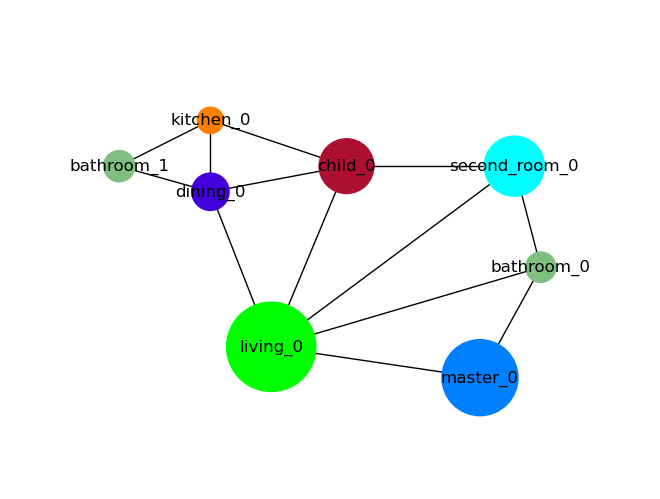

In [5]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [6]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [00:48<00:00, 1665.79it/s]


Data(edge_index=[2, 18], roomType_name=[7], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 3], edge_attr=[18, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [7]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6

    
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  9.0000,  77.0000, 210.5000]])


100%|██████████| 80787/80787 [00:06<00:00, 13030.39it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  4.0000,  77.0000, 210.5000]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [8]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        mean = torch.mean(x[:, i])
        std  = torch.std(x[:, i])
        
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:18<00:00, 4277.63it/s]


> If we need to creat graphs with padding by the maximum number of nodes.

In [11]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [9]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(device)
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        
        return G

In [10]:
edge = int(len(Graphs_pyTorch) * 0.9)
batch_size = 64

train_dataset = Planify_Dataset(Graphs_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

train: 72708, val: 8069, test: 10


In [13]:
# Saving model function
import os
checkpoint_dir = "./checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model.pth')
    # Saving model each 15 epochs
#     if epoch % 15 == 0:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

<a id='archi'></a>
### Architecture

In [78]:
class GATNet(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_node_features, 32)
        
        input_of_conv2 = 32 + 9  # output of conv1 + featurs of the real x = 9 => 41
        self.conv2 = GATConv(input_of_conv2, 32, heads=8)
        
        input_of_conv3 = 32*8 + 41 # output of conv2 + input of conv2 => 297
        self.conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4 = 64*8 + 297 # output of conv3 + input of conv3 => 809
        self.conv4 = GATConv(input_of_conv4, 64, heads=8)
        
        input_of_conv5 = 64*8 + 809 # output of conv4 + input of conv4 => 1321 
        self.conv5 = GATConv(input_of_conv5, 64, heads=16)
        
        input_of_conv6 = 64*16 + 1321 # output of conv5 + input of conv5 => 2345 
        self.conv6 = GATConv(input_of_conv6, 64, heads=16)
        
        input_of_conv7 = 64*16 + 2345 # output of conv3 + input of conv3 => 3369 
        self.conv7 = GATConv(input_of_conv7, 64, heads=16)
        
        input_of_conv8 = 64*16 + 3369 # output of conv3 + input of conv3 => 4393 
        self.conv8 = GATConv(input_of_conv8, 64, heads=16)
        
        input_of_lin1 = 64*16 + 4393 # => 5417
        self.lin1 = torch.nn.Linear(input_of_lin1, 128)
        
        input_of_lin2 = 128 + 5417 # => 5545
        self.lin2 = torch.nn.Linear(input_of_lin2, 128)
        
        self.lin3 = torch.nn.Linear(128, 64)
        
        self.regressior = torch.nn.Linear(64, 2)
        
        self.dropout = torch.nn.Dropout(p=0.25)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        if batch == None:
            batch = torch.zeros(data.x.shape[0], dtype=torch.long)
        
        x_res = x # saving a copy of x for residual connection
        
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv2(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv3(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv4(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1)
        x = F.relu(self.conv5(x_res, edge_index, edge_attr))
        x = self.dropout(x)     
        
        x_res = torch.cat([x_res, x], dim=1)
        x = F.relu(self.conv6(x_res, edge_index, edge_attr))
        x = self.dropout(x)     
        
        x_res = torch.cat([x_res, x], dim=1)
        x = F.relu(self.conv7(x_res, edge_index, edge_attr))
        x = self.dropout(x)     
        
        x_res = torch.cat([x_res, x], dim=1)
        x = F.relu(self.conv8(x_res, edge_index, edge_attr))
        x = self.dropout(x)     
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.lin1(x_res))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.lin2(x_res))
        x = self.dropout(x)
        
        x = F.relu(self.lin3(x))
        x = self.dropout(x)
        
        x = self.regressior(x)
        return x

num_features = Graphs_pyTorch[0].x.shape[1]
model = GATNet(num_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (conv1): GATConv(9, 32, heads=1)
  (conv2): GATConv(41, 32, heads=8)
  (conv3): GATConv(297, 64, heads=8)
  (conv4): GATConv(809, 64, heads=8)
  (conv5): GATConv(1321, 64, heads=16)
  (conv6): GATConv(2345, 64, heads=16)
  (conv7): GATConv(3369, 64, heads=16)
  (conv8): GATConv(4393, 64, heads=16)
  (lin1): Linear(in_features=5417, out_features=128, bias=True)
  (lin2): Linear(in_features=5545, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (regressior): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [75]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc="Planifying", total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        
        logits    = model(data)
        targets   = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
        
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)
            targets = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
            loss = criterion(out, targets)
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

<a id='train'></a>
### Training


In [76]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.001
num_epochs = 5
patience = 20 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')
best_model = None
counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)

train_losses = []
val_losses = []

In [77]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Planifying: 100%|██████████| 1137/1137 [02:57<00:00,  6.40it/s]


Validating ...
Epoch [1/5], Train Loss: 373.9185, Validation Loss: 209.8772


Planifying: 100%|██████████| 1137/1137 [02:52<00:00,  6.58it/s]


Validating ...
Epoch [2/5], Train Loss: 208.8666, Validation Loss: 306.3884
Model not saved!


Planifying: 100%|██████████| 1137/1137 [03:00<00:00,  6.31it/s]


Validating ...
Epoch [3/5], Train Loss: 181.3532, Validation Loss: 246.0479
Model not saved!


Planifying:  65%|██████▍   | 739/1137 [01:58<01:03,  6.25it/s]


KeyboardInterrupt: 

In [ ]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Planifying:   0%|          | 0/1137 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (445x2345 and 1321x1024)

In [20]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Validating ...
Epoch [1/250], Train Loss: 106.7292, Validation Loss: 102.7367
Model not saved!
Validating ...
Epoch [2/250], Train Loss: 107.0545, Validation Loss: 101.5077
Model not saved!
Validating ...
Epoch [3/250], Train Loss: 107.0885, Validation Loss: 102.1385
Model not saved!
Learning rate decreased!
Validating ...
Epoch [4/250], Train Loss: 107.0294, Validation Loss: 101.7070
Model not saved!
Validating ...
Epoch [5/250], Train Loss: 107.2129, Validation Loss: 101.7178
Model not saved!
Learning rate decreased!
Validating ...
Epoch [6/250], Train Loss: 106.6901, Validation Loss: 101.4313
Model not saved!
Validating ...
Epoch [7/250], Train Loss: 106.7046, Validation Loss: 102.1665
Model not saved!
Learning rate decreased!
Validating ...
Epoch [8/250], Train Loss: 106.9094, Validation Loss: 101.6042
Model not saved!
Validating ...
Epoch [9/250], Train Loss: 106.8180, Validation Loss: 101.8641
Model not saved!
Validating ...
Epoch [10/250], Train Loss: 106.5919, Validation Loss: 

In [21]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
    else:
        print('Model not saved!')
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in [3, 5, 7] :
            scheduler.step()
            print('Learning rate decreased!')

Validating ...
Epoch [1/250], Train Loss: 105.8150, Validation Loss: 101.3332
Model not saved!
Validating ...
Epoch [2/250], Train Loss: 105.9797, Validation Loss: 101.4282
Model not saved!
Validating ...
Epoch [3/250], Train Loss: 105.4590, Validation Loss: 101.2665
Model not saved!
Learning rate decreased!
Validating ...
Epoch [4/250], Train Loss: 105.6600, Validation Loss: 101.6902
Model not saved!
Validating ...
Epoch [5/250], Train Loss: 105.7652, Validation Loss: 101.3444
Model not saved!
Learning rate decreased!
Validating ...
Epoch [6/250], Train Loss: 106.1617, Validation Loss: 101.5592
Model not saved!
Validating ...
Epoch [7/250], Train Loss: 105.7369, Validation Loss: 101.9608
Model not saved!
Learning rate decreased!
Validating ...
Epoch [8/250], Train Loss: 105.9675, Validation Loss: 101.5100
Model not saved!
Validating ...
Epoch [9/250], Train Loss: 105.9216, Validation Loss: 101.5320
Model not saved!
Validating ...
Epoch [10/250], Train Loss: 105.6975, Validation Loss: 

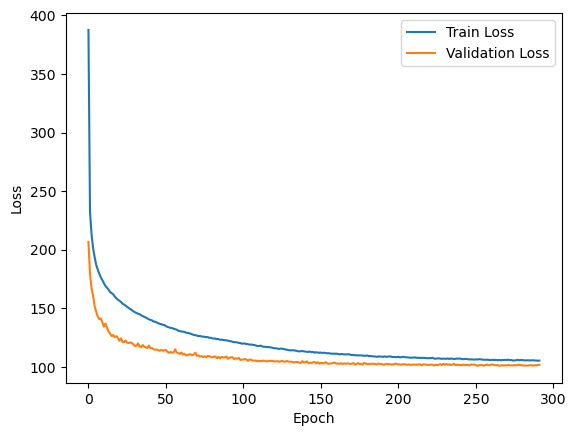

In [22]:
plt.plot(train_losses, label='Train Loss');
plt.plot(val_losses, label='Validation Loss');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend();

> Testing random graphs

In [23]:
G = val_dataset[0]
batch = torch.zeros(G.x.shape[0], dtype=torch.long)

target = torch.cat((G.rec_w.unsqueeze(1), G.rec_h.unsqueeze(1)), dim=1)

model.eval()
with torch.no_grad():
    predicted = best_model(G)

print(f"target: {target}\n\npredicted: {predicted}")

target: tensor([[ 24.,  37.],
        [ 45.,  49.],
        [ 35.,  49.],
        [ 45.,  39.],
        [ 23.,  38.],
        [111.,  64.]], device='cuda:0')

predicted: tensor([[ 37.4103,  30.9745],
        [ 52.0932,  43.7019],
        [ 39.6013,  40.1620],
        [ 40.6948,  41.6247],
        [ 26.5419,  30.9509],
        [136.3765,  64.1961]], device='cuda:0')
